In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import random

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
df = pd.read_csv("/content/drive/MyDrive/project/hrv_features_to_emotion.csv")

In [23]:
df.head(2000)

,Participant Id,Session ID,Video ID,Name,Age,Male,Valence level,Arousal level,Dominance level,Happy,...,NN50 count,pNN50 (%),LF power (ms^2),HF power (ms^2),LF/HF ratio,Total Power (ms^2),SD1 (ms),SD2 (ms),SD1/SD2,Sample Entropy
0,1,1,1,M_W,21,Female,6,0,0,Moderate,...,0.0,0.000000,0.0,0.0,NaN,0.0,4.481467,9.282317,0.482796,"(np.float64(1.6094379124341003), {'Dimension':..."
1,1,1,2,M_W,21,Female,2,4,2,VeryLow,...,0.0,0.000000,0.0,0.0,NaN,0.0,4.481467,9.282317,0.482796,"(np.float64(1.6094379124341003), {'Dimension':..."
2,1,1,3,M_W,21,Female,7,6,6,Moderate,...,0.0,0.000000,0.0,0.0,NaN,0.0,4.331894,10.567848,0.409913,"(inf, {'Dimension': 2, 'Delay': 1, 'Tolerance'..."
3,1,1,4,M_W,21,Female,7,3,4,Moderate,...,0.0,0.000000,0.0,0.0,NaN,0.0,4.294365,12.243533,0.350746,"(inf, {'Dimension': 2, 'Delay': 1, 'Tolerance'..."
4,1,1,5,M_W,21,Female,0,8,8,VeryLow,...,0.0,0.000000,0.0,0.0,NaN,0.0,4.244095,6.771444,0.626764,"(np.float64(1.9459101490553135), {'Dimension':..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,12,3,3,Q_M,11,NaN,4,9,0,VeryLow,...,0.0,0.000000,0.0,0.0,NaN,0.0,10.433786,17.223026,0.605804,"(inf, {'Dimension': 2, 'Delay': 1, 'Tolerance'..."
402,12,3,4,Q_M,11,NaN,4,0,0,High,...,0.0,0.000000,0.0,0.0,NaN,0.0,13.019616,16.571814,0.785648,"(np.float64(0.6931471805599453), {'Dimension':..."
403,12,3,5,Q_M,11,NaN,4,0,0,Moderate,...,0.0,0.000000,0.0,0.0,NaN,0.0,13.962615,35.044618,0.398424,"(inf, {'Dimension': 2, 'Delay': 1, 'Tolerance'..."
404,12,3,6,Q_M,11,NaN,2,7,2,VeryLow,...,1.0,4.545455,0.0,0.0,NaN,0.0,15.114610,46.917721,0.322151,"(np.float64(0.8873031950009028), {'Dimension':..."


In [7]:
print(df.columns)

Index(['Participant Id', 'Session ID', 'Video ID', 'Name', 'Age', 'Male',
       'Valence level', 'Arousal level', 'Dominance level', 'Happy', 'Sad',
       'Fear', 'Anger', 'Neutral', 'Disgust', 'Surprised', 'Familiarity Score',
       'Emotion', 'Valence', 'Arousal', 'Four_Label', 'raw data', 'Gender',
       'V_Label', 'A_Label', 'Four_Labels', 'R_Peaks', 'RR_Intervals',
       'RR_Intervals_ms', 'Cleaned_RR_Intervals_ms', 'Mean RR (ms)',
       'SDNN (ms)', 'Min RR (ms)', 'Max RR (ms)', 'Mean HR (bpm)',
       'STD HR (bpm)', 'Min HR (bpm)', 'Max HR (bpm)', 'RMSSD (ms)',
       'NN50 count', 'pNN50 (%)', 'LF power (ms^2)', 'HF power (ms^2)',
       'LF/HF ratio', 'Total Power (ms^2)', 'SD1 (ms)', 'SD2 (ms)', 'SD1/SD2',
       'Sample Entropy'],
      dtype='object')


In [24]:
happy_df = df[[
    'Mean RR (ms)', 'SDNN (ms)', 'Min RR (ms)', 'Max RR (ms)', 'Mean HR (bpm)',
    'STD HR (bpm)', 'Min HR (bpm)', 'Max HR (bpm)', 'RMSSD (ms)', 'NN50 count', 'pNN50 (%)',
    'LF power (ms^2)', 'HF power (ms^2)', 'Total Power (ms^2)', 'SD1 (ms)', 'SD2 (ms)', 'SD1/SD2', 'Happy', 'Emotion'
]]

In [25]:
happy_df.groupby('Happy').size()

,0
Happy,
High,27
Low,34
Moderate,42
VeryHigh,66
VeryLow,237


In [26]:
happy_df.groupby('Emotion').size()

,0
Emotion,
Anger,28
Disgust,34
Fear,35
Happy,120
Mixed,88
Neutral,37
Sad,46
Surprise,18


✅ Class weights: {0: np.float64(1.0), 1: np.float64(1.0)}
Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.4490 - loss: 0.9482 - val_accuracy: 0.6160 - val_loss: 0.6782
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5514 - loss: 0.7854 - val_accuracy: 0.4880 - val_loss: 0.6917
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5763 - loss: 0.7003 - val_accuracy: 0.5520 - val_loss: 0.6807
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6414 - loss: 0.6535 - val_accuracy: 0.5040 - val_loss: 0.6921
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6728 - loss: 0.6322 - val_accuracy: 0.6000 - val_loss: 0.6711
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6474 - loss: 0.6470 - val_accuracy: 0.5920 - val_loss: 0.6635
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5969 - loss: 0.6826 - val_accuracy: 0.5520 - val_loss: 0.6606
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step -

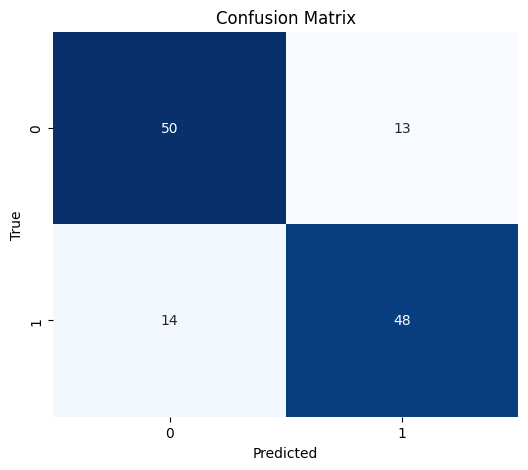

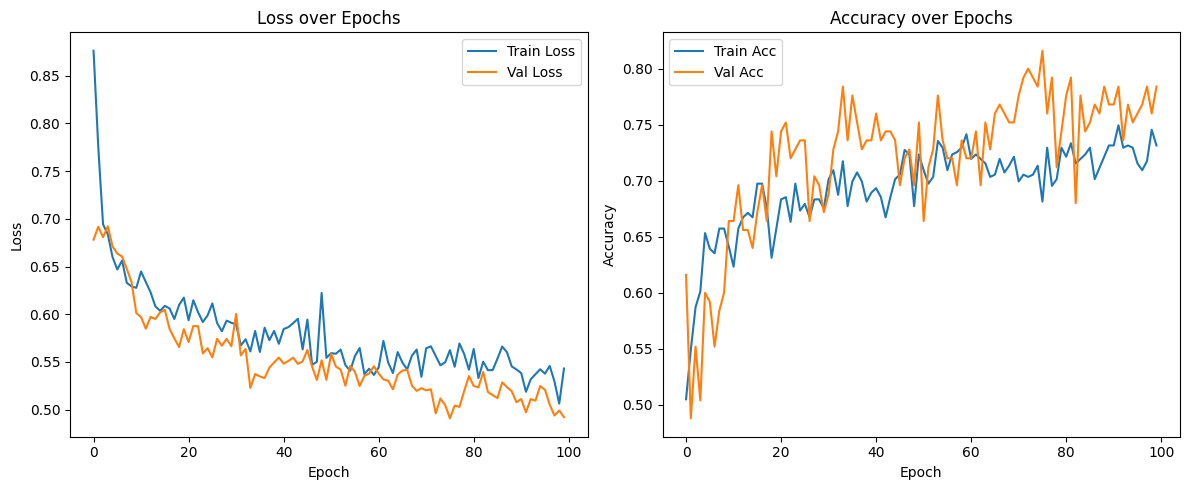

In [30]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from tensorflow.keras.layers import BatchNormalization

# === STEP 1: DEFINE happy_df ===
happy_df = df[[  # your base dataframe
    'Mean RR (ms)', 'SDNN (ms)', 'Min RR (ms)', 'Max RR (ms)', 'Mean HR (bpm)',
    'STD HR (bpm)', 'Min HR (bpm)', 'Max HR (bpm)', 'RMSSD (ms)', 'NN50 count',
    'pNN50 (%)', 'LF power (ms^2)', 'HF power (ms^2)', 'Total Power (ms^2)',
    'SD1 (ms)', 'SD2 (ms)', 'SD1/SD2', 'Happy'
]].copy()

# === STEP 2: MAP 'Happy' LABELS TO INTS ===
happy_mapping = {'VeryLow': 0, 'Low': 0, 'Moderate': 0, 'High': 1, 'VeryHigh': 1}
happy_df['Happy Encoded'] = happy_df['Happy'].map(happy_mapping)

# Drop NaNs just in case (or alternatively you can fillna)
happy_df = happy_df.dropna()

# === STEP 3: EXTRACT FEATURES AND LABELS ===
feature_cols = happy_df.drop(columns=['Happy', 'Happy Encoded']).columns.tolist()
X = happy_df[feature_cols].values
y = happy_df['Happy Encoded'].values

# === STEP 4: BALANCE WITH SMOTE ===
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# === STEP 5: ONE-HOT ENCODE LABELS ===
encoder = OneHotEncoder(sparse_output=False, categories='auto')
y_resampled_onehot = encoder.fit_transform(y_resampled.reshape(-1, 1))

# === STEP 6: SPLIT ===
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled_onehot, test_size=0.2, random_state=42, stratify=y_resampled
)

# === STEP 7: SCALE ===
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# === STEP 8: COMPUTE CLASS WEIGHTS (even after SMOTE) ===
y_resampled_flat = np.argmax(y_resampled_onehot, axis=1)
class_weights = compute_class_weight('balanced', classes=np.unique(y_resampled_flat), y=y_resampled_flat)
class_weight_dict = dict(enumerate(class_weights))
print("✅ Class weights:", class_weight_dict)

# === STEP 9: BUILD MODEL ===
def build_model(input_dim, optimizer_choice='adam', learning_rate=0.001):
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(2, activation='softmax')
])

    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    elif optimizer_choice == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError("Unsupported optimizer. Use 'adam', 'sgd', or 'rmsprop'.")

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

optimizer_choice = 'adam'
learning_rate = 0.001
model = build_model(X_train.shape[1], optimizer_choice, learning_rate)

# === STEP 10: TRAIN ===
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=16,
    class_weight=class_weight_dict,
    verbose=1
)

# === STEP 11: EVALUATE ===
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"✅ Final Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# === STEP 12: CLASSIFICATION REPORT ===
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("\n✅ Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

# === STEP 13: CONFUSION MATRIX PLOT ===
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# === STEP 14: TRAINING HISTORY PLOT ===
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [31]:
model.save("happy_from_hrv_model.keras")
model.save("happy_from_hrv_model.h5")

import joblib

# Save
joblib.dump(scaler, 'happy_from_hrv_scaler.pkl')

from google.colab import files
files.download("happy_from_hrv_model.keras")
files.download("happy_from_hrv_model.h5")
files.download('happy_from_hrv_scaler.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>